In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import AcceptanceDataset
from memflow.HH.HH import HHbbWWDoubleLeptonGenDataset,HHbbWWDoubleLeptonRecoDataset
from memflow.read_data import utils
from memflow.models.classifier import BinaryClassifier

from memflow.callbacks.classifier_callbacks import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
gen_data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    #N = 10000,
)

print (gen_data)

Data object
Loaded branches:
   ... file: 1589994
   ... sample: 1589994
   ... tree: 1589994
Branch in files not loaded:
   ... H1_E
   ... H1_Px
   ... H1_Py
   ... H1_Pz
   ... H1_eta
   ... H1_idx
   ... H1_mass
   ... H1_pdgId
   ... H1_phi
   ... H1_pt
   ... H1_sum_E
   ... H2_E
   ... H2_Px
   ... H2_Py
   ... H2_Pz
   ... H2_eta
   ... H2_idx
   ... H2_mass
   ... H2_pdgId
   ... H2_phi
   ... H2_pt
   ... H2_sum_E
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12

Selecting 1519507 events out of 1589994
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 1519507 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
leptons  : data ([1519507, 4, 4]), mask ([1519507, 4])
           Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
           Mask corr     : [True, True, True, True]
           Weights       : 1519507.00, 1519507.00, 1519507.00, 1519507.00
           Features      : ['pt', 'eta', 'phi', 'mass']
           Selected for batches : True
higgs    : data ([1519507, 2, 4]), mask ([1519507, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Weights       : 1519507.00, 1519507.00
          

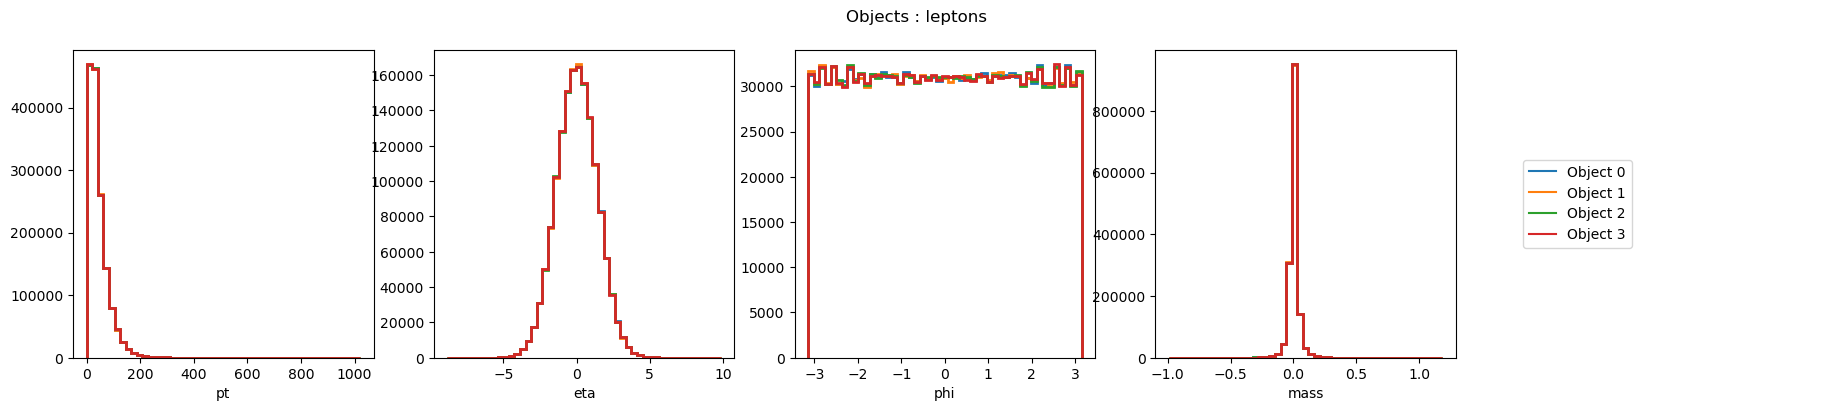

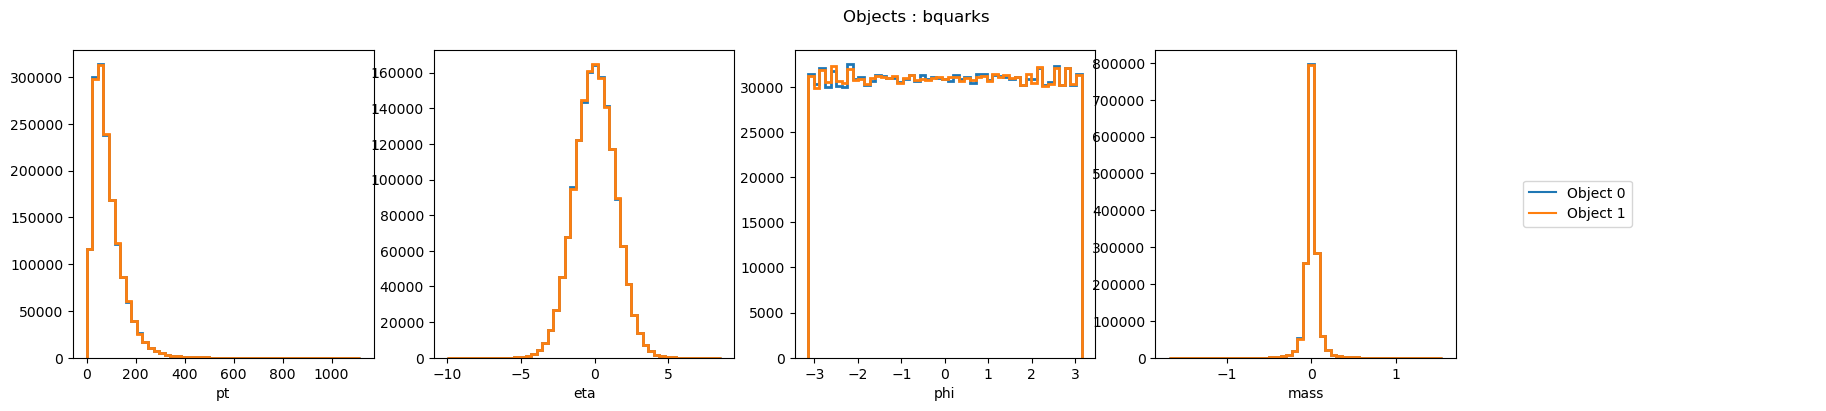

After preprocessing


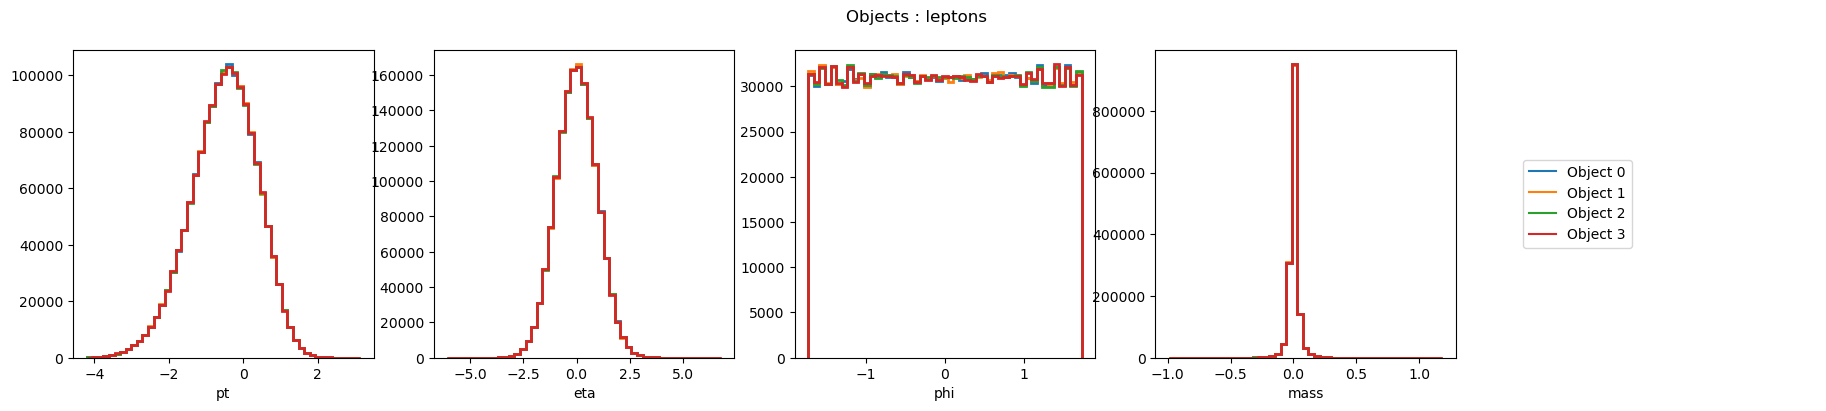

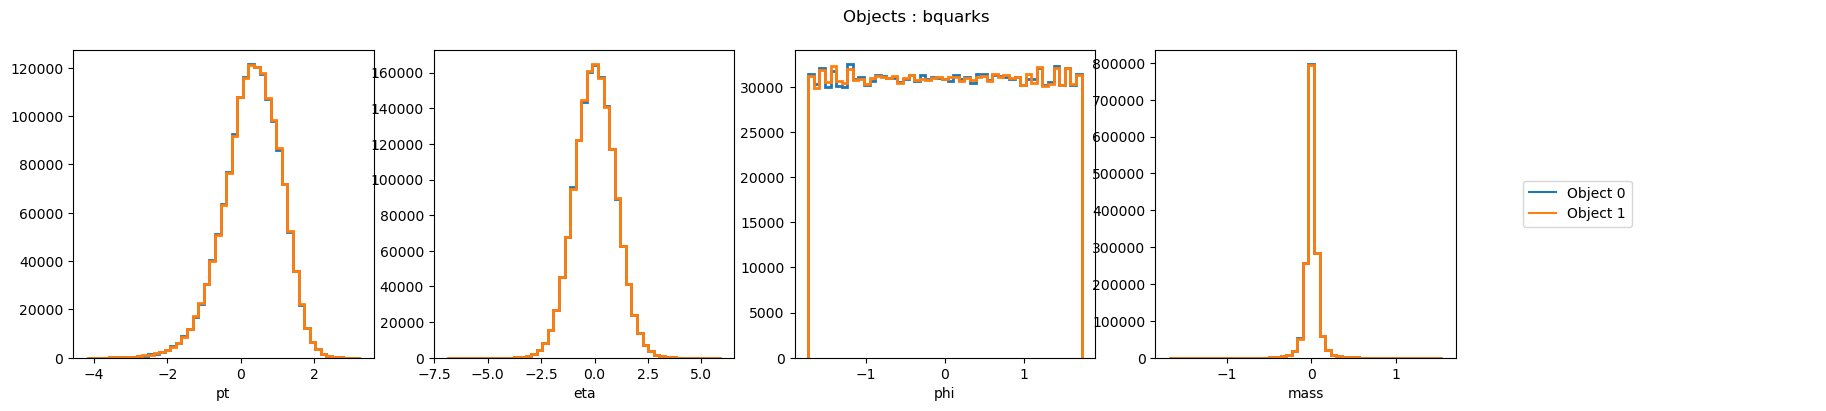

In [3]:
gen_dataset = HHbbWWDoubleLeptonGenDataset(
    data = gen_data,
    selection = [
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical',
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'mass': 0.,
        'pdgId' : None,
    },
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [4]:
reco_data = RootData(
    files = gen_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = gen_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)



Initial : 1589994
Resolved SR : 221454
Data object
Loaded branches:
   ... file: 221454
   ... flag_SR: 221454
   ... flag_resolved: 221454
   ... n_AK4: 221454
   ... sample: 221454
   ... tree: 221454
Branch in files not loaded:
   ... VBF1_E
   ... VBF1_Px
   ... VBF1_Py
   ... VBF1_Pz
   ... VBF1_eta
   ... VBF1_idx
   ... VBF1_mass
   ... VBF1_phi
   ... VBF1_pt
   ... VBF1_sel
   ... VBF2_E
   ... VBF2_Px
   ... VBF2_Py
   ... VBF2_Pz
   ... VBF2_eta
   ... VBF2_idx
   ... VBF2_mass
   ... VBF2_phi
   ... VBF2_pt
   ... VBF2_sel
   ... VBF3_E
   ... VBF3_Px
   ... VBF3_Py
   ... VBF3_Pz
   ... VBF3_eta
   ... VBF3_idx
   ... VBF3_mass
   ... VBF3_phi
   ... VBF3_pt
   ... VBF3_sel
   ... VBF4_E
   ... VBF4_Px
   ... VBF4_Py
   ... VBF4_Pz
   ... VBF4_eta
   ... VBF4_idx
   ... VBF4_mass
   ... VBF4_phi
   ... VBF4_pt
   ... VBF4_sel
   ... VBF5_E
   ... VBF5_Px
   ... VBF5_Py
   ... VBF5_Pz
   ... VBF5_eta
   ... VBF5_idx
   ... VBF5_mass
   ... VBF5_phi
   ... VBF5_pt
   ... VBF

In [5]:
dataset = AcceptanceDataset(
    gen_dataset = gen_dataset,
    reco_data = reco_data,
    intersection_branch = 'event',
)

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
	entry 1 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
Will only consider common files : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu

In [6]:
train_frac = 0.8
indices = torch.arange(len(dataset))
sep = int(train_frac*len(dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

dataset_train = torch.utils.data.Subset(dataset,train_indices)
dataset_valid = torch.utils.data.Subset(dataset,valid_indices)
print (len(dataset_train),len(dataset_valid))

batch_size = 1024

loader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_valid = DataLoader(
    dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

1215605 303902


In [7]:
model = BinaryClassifier(
    number_objects = dataset.number_objects,
    dim_features = dataset.dim_features,
    neurons = [256]*6,
    hidden_activation = nn.ReLU,
    batch_norm = True,
    dropout = 0.1,
)
print (model)

batch = next(iter(loader_train))

model.shared_eval(batch,0,'test')

BinaryClassifier(
  (hidden_layers): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(256, eps=1e-05, 

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(0.7447, grad_fn=<BinaryCrossEntropyBackward0>)

Predict: 100%|████████████████████████████████| 152/152 [00:12<00:00, 12.27it/s]


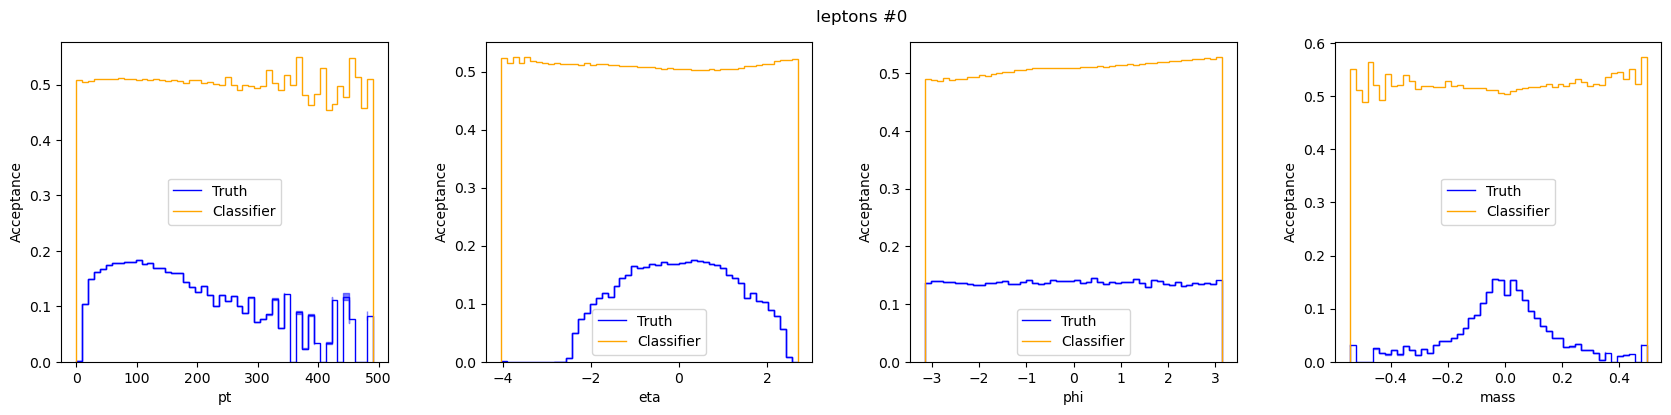

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


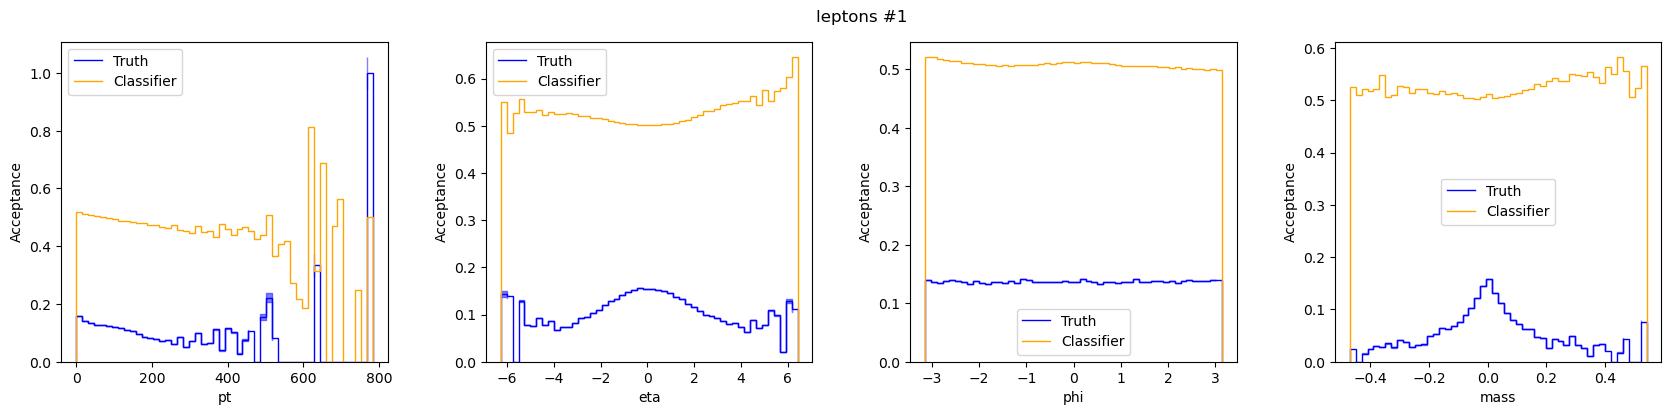

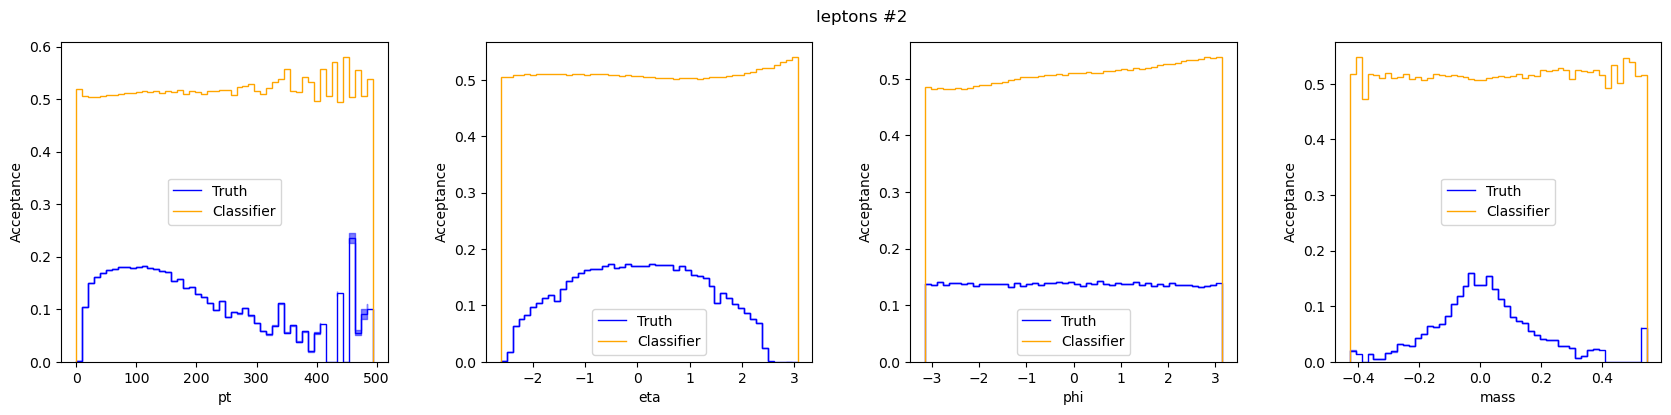

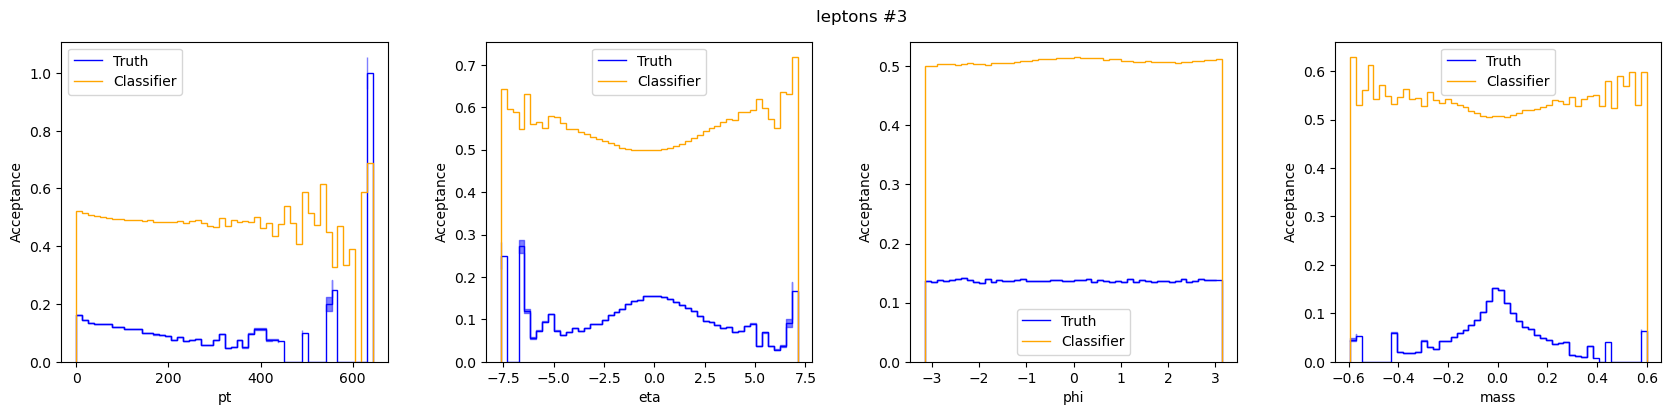

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


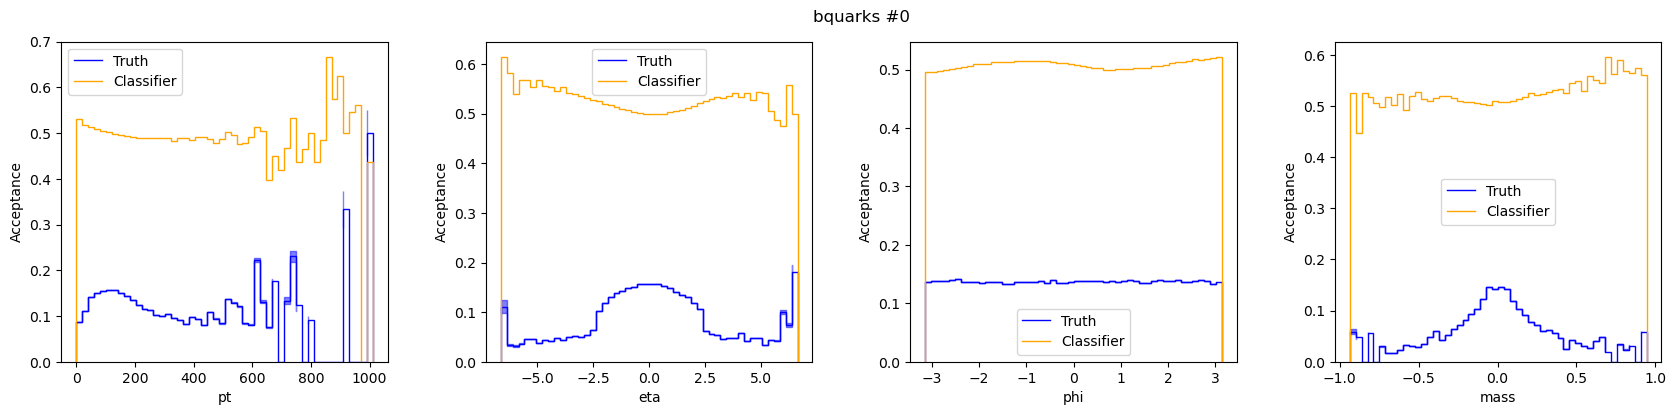

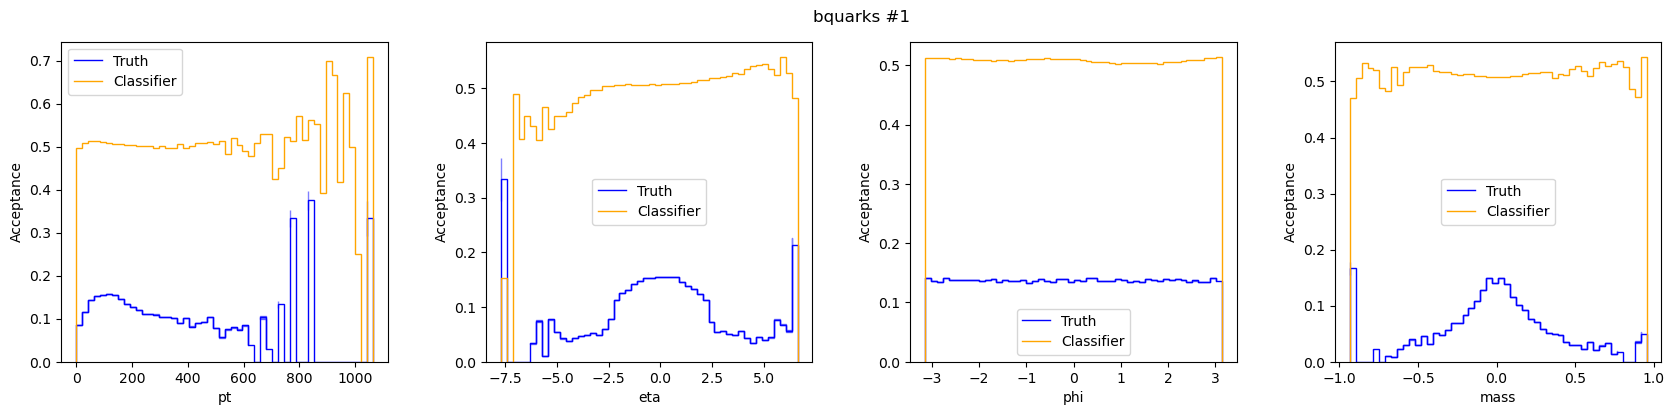

In [8]:
model = model.cuda()
acceptance = AcceptanceCallback(
    dataset = dataset,
    frequency = 5,
    raw = True,
    bins = 50,
    batch_size=10000,
)

figs = acceptance.make_plots(model=model,show=True)

In [9]:
##### Parameters #####
epochs = 20
steps_per_epoch_train = math.ceil(len(dataset_train)/loader_train.batch_size)

print (f'Training   : Batch size = {loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.20, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=1e1, 
    final_div_factor=1e3,
)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer = optimizer,
#     mode='min', 
#     factor=0.1, 
#     patience=10, 
#     threshold=0.001, 
#     threshold_mode='rel', 
#     cooldown=5, 
#     min_lr=1e-7
# )
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    acceptance,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'Acceptance',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_train,
    val_dataloaders = loader_valid,
)

Training   : Batch size = 1024 => 1188 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/9fe7cd01854b4cfd8854c9d05d21faed

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:100: RuntimeWarning: invalid value encountered in divide
  content_acc = np.nan_to_num(content_selected / content_feat, nan=0.)
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:106: RuntimeWarning: invalid value encountered in divide
  content_pred_avg = content_pred_weighted / content_pred_tot


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Acceptance
COMET INFO:     url                   : https://www.comet.com/florianbury/mem-flow-hh/9fe7cd01854b4cfd8854c9d05d21faed
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler [20]      : (9.690285362199111e-06, 0.0009999999931715289)
COMET INFO:     train/loss_tot [20] : (0.2639450430870056, 0.42753100395202637)
COMET INFO:     val/loss_tot [20]   : (0.30997201800346375, 0.35197964310646057)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Acceptance
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET I

Predict: 100%|████████████████████████████████| 152/152 [00:28<00:00,  5.36it/s]


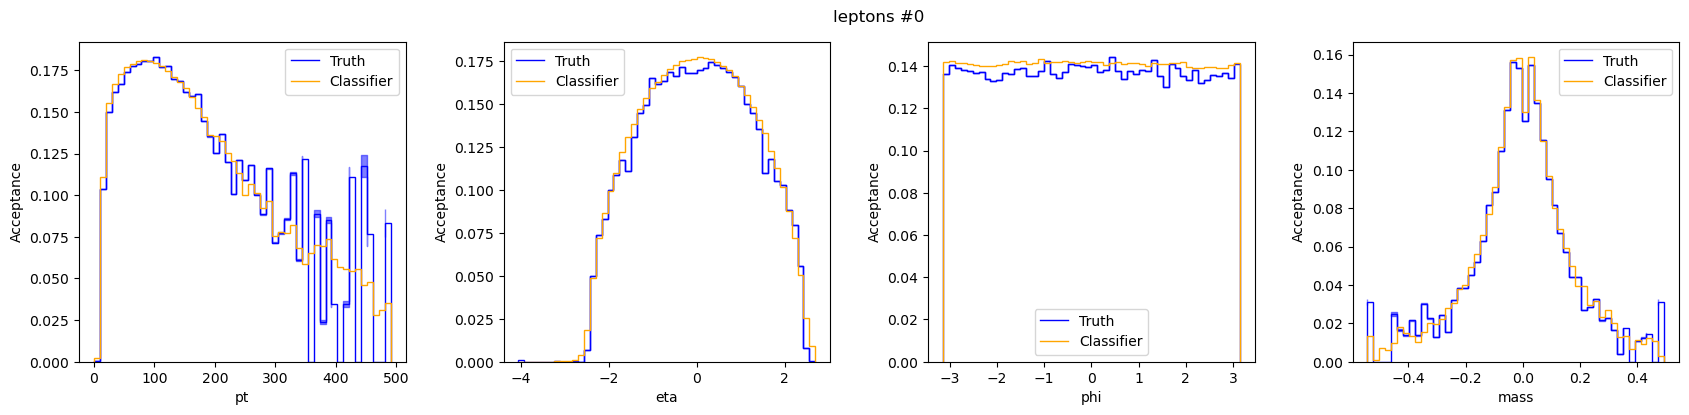

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:101: RuntimeWarning: invalid value encountered in divide
  #https://indico.cern.ch/event/66256/contributions/2071577/attachments/1017176/1447814/EfficiencyErrors.pdf
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:107: RuntimeWarning: invalid value encountered in divide
  


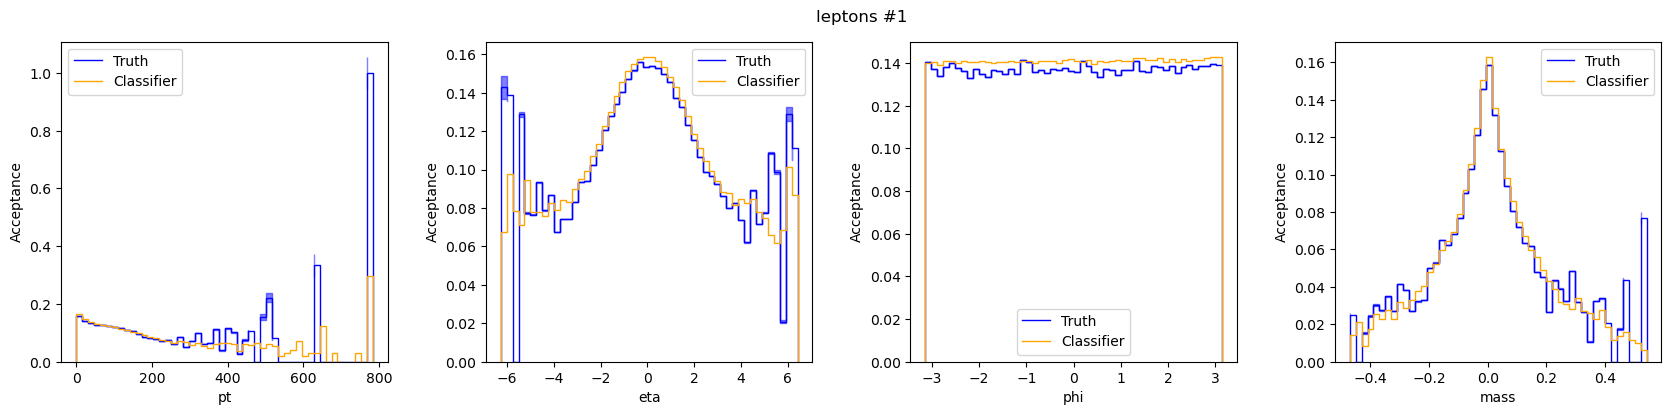

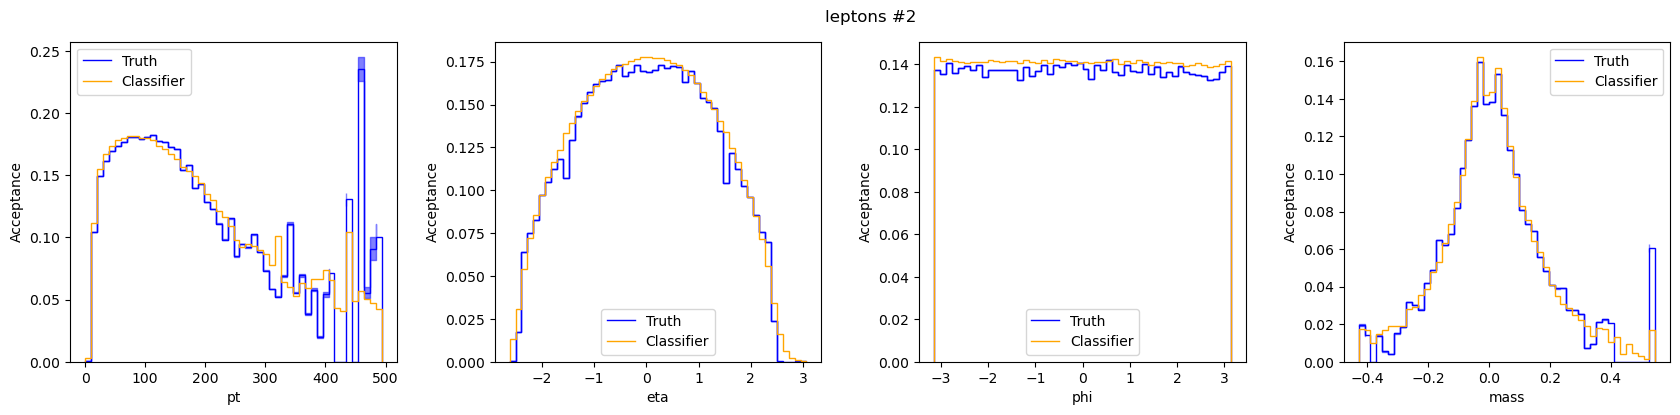

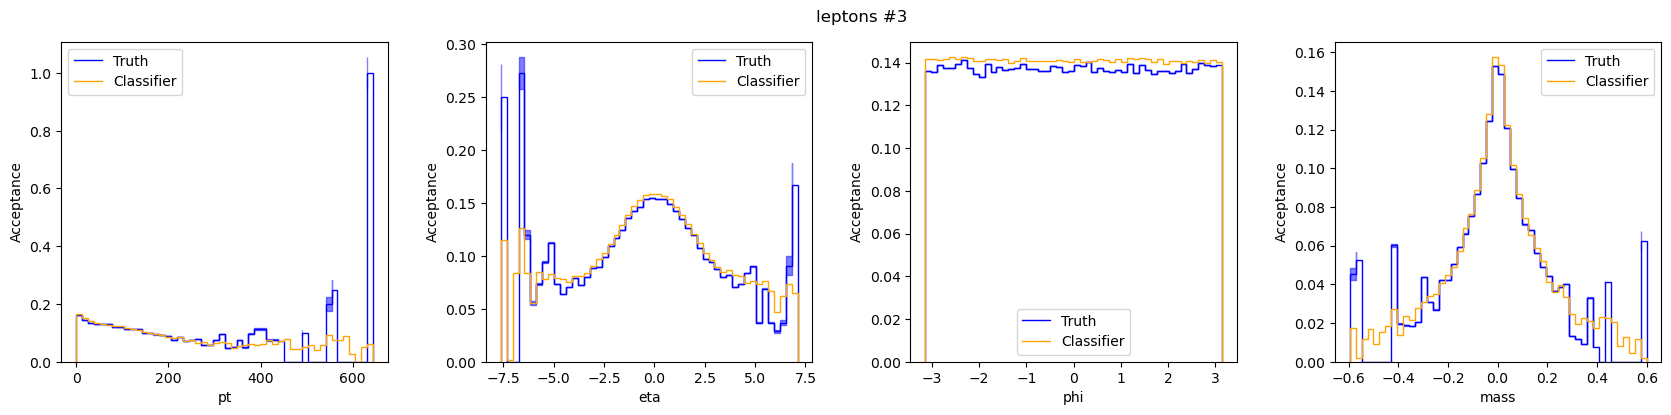

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:101: RuntimeWarning: invalid value encountered in divide
  #https://indico.cern.ch/event/66256/contributions/2071577/attachments/1017176/1447814/EfficiencyErrors.pdf
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/classifier_callbacks.py:107: RuntimeWarning: invalid value encountered in divide
  


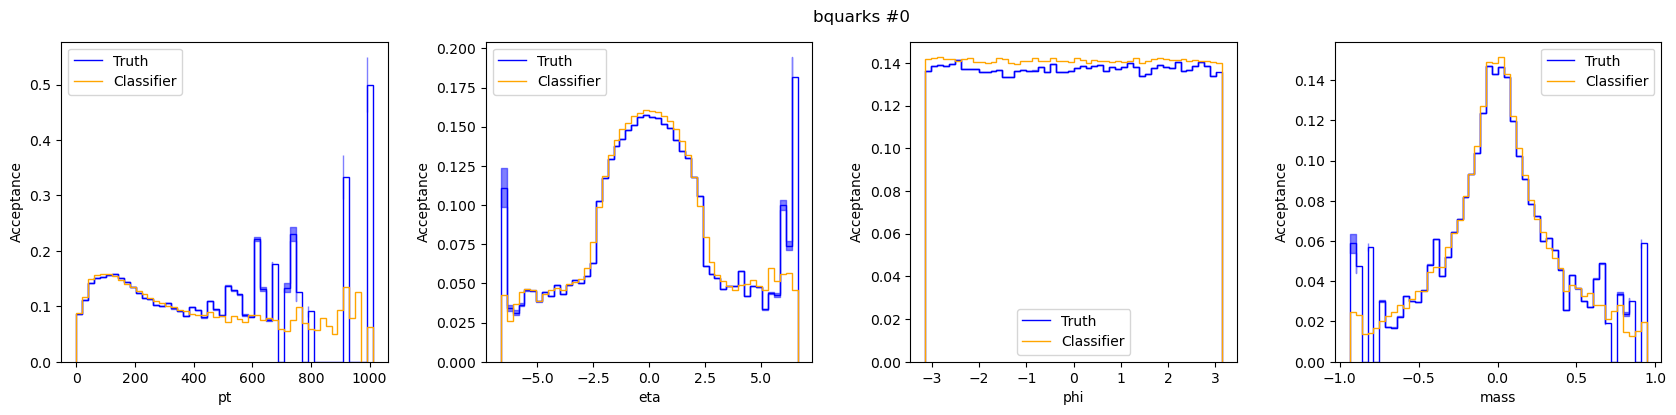

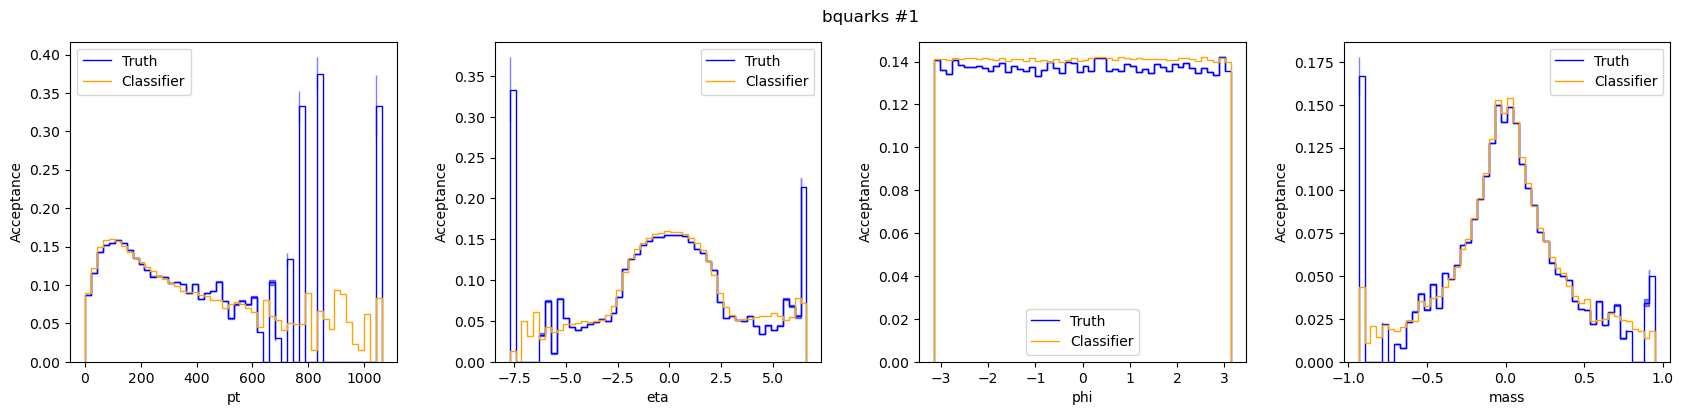

In [12]:
figs = acceptance.make_plots(model=model,show=True)